# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import os 

os.chdir("/Users/guillaume/Desktop/nlp_project")

In [2]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path

In [3]:
from urllib.request import urlretrieve

In [4]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [5]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)                                 
                embeddings.append(np.fromstring(vec, sep=' '))     
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        '''
        Inputs:
        -word : mot
        
        Output:
        - l'embedding du mot correspondant
        '''
        if word in self.words : 
            row = self.embeddings[self.word2id[word],:]
            return(row)
        
        else : 
            return(np.zeros((1, self.embeddings.shape[1])))  #si le mot n'est pas dans le dictionnaire
    
    def score(self, word1, word2):
        '''
        Inputs:
        -word1, word2 : mot
        
        Output:
        -score des deux mots
        '''
        
        if (word1 in self.words) and (word2 in self.words):  #si les mots sont dans le dictionnaire
            #on met sous forme d'embedding les mots
            emb1 = self.encode(word1)
            emb2 = self.encode(word2)
            #on calcule le score
            score = np.dot(emb1, emb2)/ (np.linalg.norm(emb1) * np.linalg.norm(emb2))
            return(score)
        
        else:  #si le mot n'est pas dans le dictionnaire
            return(0) 
            

    def most_similar(self, word, k=5):
        '''
        Inputs:
        - word : mot
        - k : un réel 
        
        Output:
        - best_words : liste des k+1 les plus similaire à word (on renvoie en 1er word pour vérifier la fonction
        + les k autres)
        '''
        #on calcule l'ensemble des scores
        liste_score = [self.score(word, w) for w in self.words] 
        #on trie et ressort les k+1 meilleures mots.
        index = np.argsort(liste_score)[::-1][0:k+1]
        best_words = [ self.id2word[idx] for idx in index]
        
        return(best_words)
        
        

In [7]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.2644975466165475
cat dog 0.7078641298542562
cat pet 0.6753313359976381
Paris France 0.6892958925806542
Paris Germany 0.4051242286737548
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348005
['cat', 'cats', 'kitty', 'kitten', 'feline', 'dog']
['dog', 'dogs', 'puppy', 'pup', 'canine', 'pet']
['dogs', 'dog', 'cats', 'puppies', 'Dogs', 'pets']
['Paris', 'France', 'Parisian', 'Marseille', 'Brussels', 'Strasbourg']
['Germany', 'Austria', 'Europe', 'Berlin', 'Hamburg', 'Bavaria']


In [68]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def build_idf(self, sentences):
        '''
        Inputs :
        - sentences : liste de phrases
        
        Ouput : 
        - idf : dictionnaire des idf des mots
        '''
        #On construit le dictionnaire des mots. (ref "https://www.journaldunet.fr/web-tech/developpement/1202879-python-comment-verifier-si-une-cle-key-existe-dans-un-dictionnaire/")
        idf = {}
        for phrase in sentences:
            for word in phrase.split(' '):
                idf[word] = idf.get(word, 0) + 1
        
        #on calcule l'idf des mots
        for w in idf.keys():
            idf[w] = np.log10(len(sentences) / (idf[w]))
        return idf
    
    def encode(self, sentence, idf=None):
        '''
        Inputs:
        - sentence : une phrase
        -idf : None si on encode sans tenir compte de l'idf. True si oui
        
        Output:
        - la phrase encodée
        '''
       
        if idf is None:
            # mean of word vectors
            emb_sentence = [self.word2vec.encode(word) for word in sentence.split(' ') if word in self.word2vec.words]
            return( np.mean(emb_sentence, axis = 0) )
 
        else:
            # idf-weighted mean of word vectors
            emb_sentence = np.array([self.word2vec.encode(word)*idf[word] for word in sentence.split(' ') if word in self.word2vec.words])
            idf_sentence = [idf[word] for word in sentence.split(' ')]
            return( np.sum(emb_sentence, axis = 0) / np.sum(idf_sentence) ) 

    def score(self, sentence1, sentence2, idf=None):
        ''' 
        Inputs : 
        - sentence1, sentence2 : phrase (encodée ou non)
        - idf : None si on encode sans tenir compte de l'idf. True si oui
        
        Output:
        - score des deux phrases
        '''
        
        #si sentences1 & sentence2 sont en string, on les encode
        if type(sentence1) == str : 
            sentence1 = self.encode(sentence1, idf)
            sentence2 = self.encode(sentence2, idf)
        
        #Pour éviter des problèmes dans la formule du score    
        if (np.linalg.norm(sentence1) == 0) or (np.linalg.norm(sentence2) == 0):
            return(0)
        
        else : 
            return( sentence1.dot(sentence2) / (np.linalg.norm(sentence1) * np.linalg.norm(sentence2)) )
        
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        '''
        Inputs : 
        - sentence : phrase objective
        - sentences : listes de phrases
        - k : réel 
        
        Output:
        - phrase : les k+1 phrases les plus similaires (on renvoie en 1er sentence pour vérifier la fonction
        + les k autres)'''
        
        # Return most similar sentences
        query = self.encode(sentence, idf)
        keys = np.vstack([self.encode(sentence, idf) for sentence in sentences]) 
        
        #liste des score entre sentence et notre liste 
        score = [self.score(query, sent, idf) for sent in keys]   
        
        #on prend les k phrases correspondantes
        index = np.argsort(score)[::-1][0:k+1]
        phrase = [ sentences[idx] for idx in index]
        return( phrase )

In [21]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.7065220648251476
1 smiling african american boy . 
1) 1 smiling african american boy . 
2) 2 woman dancing while pointing . 
3) 5 women and 1 man are smiling for the camera . 
4) a small boy following 4 geese . 
5) 2 female babies eating chips . 
6) a young boy and 2 girls open christmas presents . 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6230172138542663
a young boy and 2 girls open christmas presents . 
1) a young boy and 2 girls open christmas presents . 
2) 3 girls and one boy playing in the street . 
3) a group of friends , 3 boys and 2 girls , jump in the air holding hands for a photo . 
4) five children , 3 boys and 2 girls playing soccer in a grass field . 
5) 2 kids holding hands and smil

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [39]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        
        # 1 - Get words that appear in both vocabs (= identical character strings)
        commun = [word for word in self.fr_word2vec.words if word in self.en_word2vec.words]
        
        #on encode nos mots
        X, Y = np.empty([300,len(commun)]),np.empty([300,len(commun)])
        for i, word in enumerate(commun) : 
            X[:,i] = self.fr_word2vec.encode(word)
            Y[:,i] = self.en_word2vec.encode(word)
        assert X.shape[0] == 300 and Y.shape[0] == 300
                          
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        U, s, Vh = np.linalg.svd(Y.dot(X.T))
        W = U.dot(Vh)
        self.W = W

        return np.matmul(self.fr_word2vec.embeddings, W.transpose())
        
    def get_closest_english_words(self, fr_word, k=3):
        '''
        Inputs:
        - fr_word : mot en fançais
        - k : réel
        
        Output:
        -renvoie les k mots les plus proches dans la traduction
        '''
        
        fr_obj = self.fr_word2vec.encode(fr_word)
        aligne_fr = self.W.dot(fr_obj)
        en_embeds = self.en_word2vec.embeddings
        norm_prod = np.linalg.norm(aligne_fr)*np.linalg.norm(en_embeds, axis=1)
        scores = en_embeds @ aligne_fr / norm_prod
        best_k = np.flip(np.argsort(scores))[:k]
        return [self.en_word2vec.words[idx] for idx in best_k]
            
        

In [15]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [6]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

with open(train_filepath, 'r') as f:
    phrases = [line.strip('\n') for line in f]
    y_train = [int(line[0]) for line in phrases]
    x_train = [line[2:] for line in phrases]
    
with open(dev_filepath, 'r') as f:
    phrases = [line.strip('\n') for line in f]
    y_dev = [int(line[0]) for line in phrases]
    x_dev = [line[2:] for line in phrases]

with open(train_filepath, 'r') as f:
    phrases = [line.strip('\n') for line in f]
    x_test = [line for line in phrases]
    
#les x sont nos phrases    

In [85]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

#sans idf
x_train_emb = [sentence2vec.encode(x_train[i]) for i in range(len(x_train))]
x_dev_emb = [sentence2vec.encode(x_dev[i]) for i in range(len(x_dev))]
x_test_emb = [sentence2vec.encode(x_test[i]) for i in range(len(x_test))]

#avec idf
idf = sentence2vec.build_idf(x_train+x_dev+x_test)

x_train_emb_idf = [sentence2vec.encode(x_train[i], idf) for i in range(len(x_train))]
x_dev_emb_idf = [sentence2vec.encode(x_dev[i], idf) for i in range(len(x_dev))]
x_test_emb_idf = [sentence2vec.encode(x_test[i], idf) for i in range(len(x_test))]


#on a nos phrases encodées & on les normalise
from sklearn.preprocessing import scale

x_train_emb_scale = scale(x_train_emb, axis=0)
x_dev_emb_scale = scale(x_dev_emb, axis=0)
x_test_emb_scale = scale(x_test_emb, axis=0)

x_train_emb_idf_scale = scale(x_train_emb_idf, axis=0)
x_dev_emb_idf_scale = scale(x_dev_emb_idf, axis=0)
x_test_emb_idf_scale = scale(x_test_emb_idf, axis=0)

Loaded 50000 pretrained word vectors


In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set) 

parameters = {'C':[0.01, 0.05, 0.1, 0.5, 1, 2]}

#sans idf
clf = GridSearchCV(LogisticRegression(penalty="l2", solver="liblinear", multi_class='ovr', tol=1e-6), parameters)
clf.fit(x_train_emb_scale, y_train)
print("Sans idf, mon meilleur score est", clf.score(x_dev_emb_scale,y_dev), "avec un paramètre de ", clf.best_params_)

#avec idf
clf_idf = GridSearchCV(LogisticRegression(penalty="l2", solver="liblinear", multi_class='ovr', tol=1e-6), parameters)
clf_idf.fit(x_train_emb_idf_scale, y_train)
print("Avec idf, mon meilleur score est", clf_idf.score(x_dev_emb_idf_scale,y_dev), "avec un paramètre de ", clf_idf.best_params_)


Sans idf, mon meilleur score est 0.410535876475931 avec un paramètre de  {'C': 0.01}
Avec idf, mon meilleur score est 0.40417801998183467 avec un paramètre de  {'C': 0.01}


In [52]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set


pred_test= clf.predict(x_test_emb_scale)

with open("logreg_bov_y_test_sst.txt", 'w+') as f:
    for p in pred_test:
        f.write(str(p) + '\n')

In [74]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# Cette cellule met beaucoup de temps à runner à cause des nombreux entraînements

#Essayons avec une random forest
from sklearn.ensemble import RandomForestRegressor

#sans idf
print('Random forest sans idf...')
ran_for = RandomForestRegressor()
ran_for.fit(x_train_emb_scale, y_train)

print("La précision du BoW classique pour le train_set est", ran_for.score(x_train_emb_scale, y_train))
print("La précision du BoW classique pour le dev_set est", ran_for.score(x_dev_emb_scale, y_dev))


#avec idf
print('Random forest avec idf...')
ran_for_idf = RandomForestRegressor()
ran_for_idf.fit(x_train_emb_idf_scale , y_train)

print("La précision du BoW avec Idf pour le train_set est", ran_for_idf.score(x_train_emb_idf_scale , y_train))
print("La précision du BoW avec Idf pour le dev_set est", ran_for.score(x_dev_emb_idf_scale, y_dev))



#Essayons avec un réseau de neurones
from sklearn.neural_network import MLPClassifier

#sans idf
print('Réseau de neurones sans idf...')
mlp = MLPClassifier(random_state=10, hidden_layer_sizes=(128,), alpha=1e-1, early_stopping=True)
mlp.fit(x_train_emb_scale, y_train)

print("La précision du BoW classique pour le train_set est", mlp.score(x_train_emb_scale, y_train))
print("La précision du BoW classique pour le dev_set est", mlp.score(x_dev_emb_scale, y_dev))


#avec idf
print('Réseau de neurones avec idf...')
mlp_idf = MLPClassifier(random_state=10, hidden_layer_sizes=(128,), alpha=1e-1, early_stopping=True)
mlp_idf.fit(x_train_emb_idf_scale, y_train)

print("La précision du BoW avec Idf pour le train_set est", mlp_idf.score(x_train_emb_idf_scale, y_train))
print("La précision du BoW avec Idf pour le dev_set est", mlp_idf.score(x_dev_emb_idf_scale, y_dev))


#on envoie le meilleur
pred_test= mlp.predict(x_test_emb_scale)

with open("MLP_bov_y_test_sst.txt", 'w+') as f:
    for p in pred_test:
        f.write(str(p) + '\n')

Random forest sans idf...
La précision du BoW classique pour le train_set est 0.8880125908929122
La précision du BoW classique pour le dev_set est 0.22311638117927046
Random forest avec idf...
La précision du BoW avec Idf pour le train_set est 0.8960507527424993
La précision du BoW avec Idf pour le dev_set est 0.2352078167484959
Réseau de neurones sans idf...
La précision du BoW classique pour le train_set est 0.5829822097378277
La précision du BoW classique pour le dev_set est 0.3869209809264305
Réseau de neurones avec idf...
La précision du BoW avec Idf pour le train_set est 0.6308520599250936
La précision du BoW avec Idf pour le dev_set est 0.38419618528610355


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [7]:
import tensorflow as tf
import keras.preprocessing 
from keras.utils import to_categorical
import warnings
from keras.preprocessing import text
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [8]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
#from keras.preprocessing import text
#from keras.utils import to_categorical

vocab = 50000

x_train_pp = [keras.preprocessing.text.one_hot(phrase, n = vocab, split = ' ') for phrase in x_train]
x_dev_pp = [keras.preprocessing.text.one_hot(phrase, n = vocab, split = ' ') for phrase in x_dev]
x_test_pp = [keras.preprocessing.text.one_hot(phrase, n = vocab, split = ' ') for phrase in x_test]


y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
print(y_train.shape)

(8544, 5)


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [9]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing.sequence import pad_sequences


#parmi toutes, 44 pour le dev, 48 pour le train et 50 pour le test. On garde 50
x_train_pad = pad_sequences(x_train_pp, maxlen = 50)
x_dev_pad = pad_sequences(x_dev_pp, maxlen = 50)
x_test_pad = pad_sequences(x_test_pp, maxlen = 50)

## 4.2 - Design and train your model

In [10]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 300    # word embedding dimension
nhid       = 100    # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='softmax'))

In [40]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'rmsprop'                  # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         15000000  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 5)                 505       
Total params: 15,160,905
Trainable params: 15,160,905
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 49s 6ms/sample - loss: 0.4109 - accuracy: 0.8571 - val_loss: 2.0151 - val_accuracy: 0.3924
Epoch 2/6
8544/8544 [==============================] - 49s 6ms/sample - loss: 0.3285 - accuracy: 0.8861 - val_loss: 2.1762 - val_accuracy: 0.3778
Epoch 3/6
8544/8544 [==============================] - 50s 6ms/sample - loss: 0.2678 - accuracy: 0.9078 - val_loss: 2.4168 - val_accuracy: 0.3733
Epoch 4/6
8544/8544 [==============================] - 49s 6ms/sample - loss: 0.2145 - accuracy: 0.9266 - val_loss: 2.5622 - val_accuracy: 0.3579
Epoch 5/6
8544/8544 [==============================] - 49s 6ms/sample - loss: 0.1787 - accuracy: 0.9393 - val_loss: 2.6242 - val_accuracy: 0.3406
Epoch 6/6
8544/8544 [==============================] - 49s 6ms/sample - loss: 0.1474 - accuracy: 0.9505 - val_loss: 2.8890 - val_accuracy: 0.3451


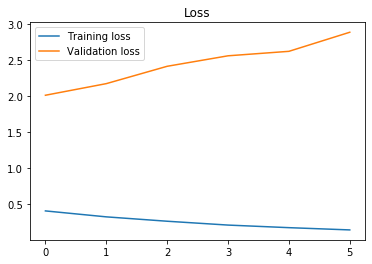

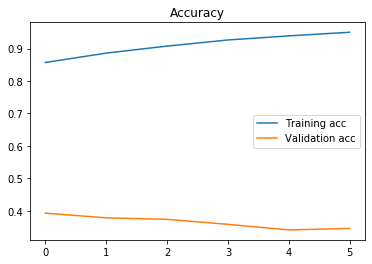

In [44]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)


# ADAPT CODE BELOW
bs = 64
n_epochs = 6

history = model.fit(x_train_pad, y_train, batch_size=bs, nb_epoch = n_epochs, validation_data = (x_dev_pad, y_dev))

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Loss")
plt.show()

fig = plt.figure()
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.legend()
plt.title("Accuracy")
plt.show()

In [52]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
pred_test = np.argmax(model.predict(x_test_pad), axis = 1)
with open("logreg_lstm_y_test_sst.txt", "w+") as g:
    for p in pred_test:
        g.write(str(p) + '\n')    

## 4.3 - innovate !

In [58]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.datasets import imdb
from keras.preprocessing import text
from keras.callbacks import ModelCheckpoint, EarlyStopping



# on sépare par mot
X_seq = [text.text_to_word_sequence(sent) for sent in x_train]
X_dev_seq = [text.text_to_word_sequence(sent) for sent in x_dev]
X_test_seq = [text.text_to_word_sequence(sent) for sent in x_test]

#on crée notre dico de mot
dic = {} 
count = 0
for seq in (X_seq + X_dev_seq + X_test_seq):
    for word in seq:
        if word not in dic.keys():
            #on met à jour le dico
            dic[word] = count
            count += 1

#on réduit la taille du vocabulaire        
vocab_size = len(dic.keys())   
print("Notre vocabulaire a une taille de :", vocab_size)

#on crée notre nouvelle matrice d'embedding
print("Création de notre matrice d'embedding...")
w2v = Word2Vec(en_embeddings_path, vocab_size=200000)
w2v_voc = w2v.words
w2v_emb = w2v.embeddings
embedding_matrix = np.empty((len(dic.keys()), 300))
for seq in (X_seq + X_dev_seq + X_test_seq):
    for word in seq:
        if word in w2v_voc : 
            embed = w2v_emb[w2v.word2id[word],:]
            embedding_matrix[dic[word]] = embed


#on encode nos phrases
def encode(sentence):
    """
    Inputs :
    -sentence : liste de mots
    
    Output: 
    - l : liste des mots encodés selon le nouveau dictionnaire
    """
    l = []
    for word in sentence:
        l.append(dic[word])   
    return(l)

print("Encoding...")
X_encoded = [encode(sentence) for sentence in X_seq]
X_dev_encoded = [encode(sentence) for sentence in X_dev_seq]
X_test_encoded = [encode(sentence) for sentence in X_test_seq]


#on pad nos phrases
print("Padding")
X_train_pad = pad_sequences(X_encoded, maxlen = 50)
X_dev_pad = pad_sequences(X_dev_encoded, maxlen = 50)
X_test_pad = pad_sequences(X_test_encoded, maxlen = 50)


#hyperparamètres
embed_dim  = 300  # word embedding dimension
nhid       = 50  # number of hidden units in the LSTM
vocab_size = embedding_matrix.shape[0]  # size of the vocabulary
n_classes  = 5
bs = 128
n_epochs = 25


#modèle
mod = Sequential()
mod.add(Embedding(vocab_size, embed_dim, trainable = False, weights = [embedding_matrix]))
mod.add(LSTM(nhid, dropout=0.5))
mod.add(Dense(128, activation = 'relu'))
mod.add(Dropout(0.5))
mod.add(Dense(n_classes, activation='softmax'))

loss_classif     =  'categorical_crossentropy'
optimizer        =  'adam' 
metrics_classif  =  ['accuracy']

mod.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)

#training
print("Début du train...")
history = mod.fit(X_train_pad, y_train, batch_size=bs, nb_epoch=n_epochs, 
                    validation_data=(X_dev_pad, y_dev))

loss, acc = mod.evaluate(X_dev_pad, y_dev, batch_size=bs)

print('perte validation:', loss)
print('précision validation:', acc)

Notre vocabulaire a une taille de : 16219
Création de notre matrice d'embedding...
Loaded 200000 pretrained word vectors
Encoding...
Padding
Début du train...
Train on 8544 samples, validate on 1101 samples
Epoch 1/25
8544/8544 [==============================] - 26s 3ms/step - loss: 1.5751 - accuracy: 0.2767 - val_loss: 1.5604 - val_accuracy: 0.3034
Epoch 2/25
8544/8544 [==============================] - 20s 2ms/step - loss: 1.5485 - accuracy: 0.3040 - val_loss: 1.4983 - val_accuracy: 0.3324
Epoch 3/25
8544/8544 [==============================] - 20s 2ms/step - loss: 1.4873 - accuracy: 0.3422 - val_loss: 1.4150 - val_accuracy: 0.3597
Epoch 4/25
8544/8544 [==============================] - 21s 2ms/step - loss: 1.4449 - accuracy: 0.3642 - val_loss: 1.3826 - val_accuracy: 0.3678
Epoch 5/25
8544/8544 [==============================] - 22s 3ms/step - loss: 1.4170 - accuracy: 0.3771 - val_loss: 1.3684 - val_accuracy: 0.3869
Epoch 6/25
8544/8544 [==============================] - 23s 3ms/step

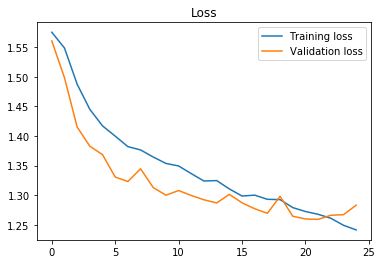

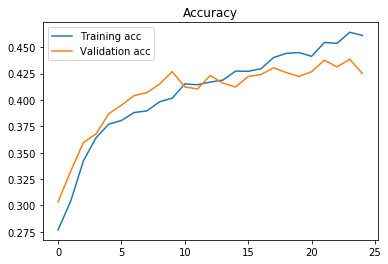

In [60]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Loss")

fig = plt.figure()
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.legend()
plt.title("Accuracy")

pred_test = np.argmax(mod.predict(X_test_pad), axis = 1)

with open("XXX_XXX_y_test-sst.txt", "w+") as file:
    for p in pred_test:
        file.write(str(p) + '\n') 